In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import savgol_filter
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

import warnings
warnings.filterwarnings('ignore')

In [3]:
# konfigurasi parameter

selected_kec = 'warungkondang'
selected_clim = 'OpenWeather'
evi = True

climate_dir = f"climate_timeseries/cleaned/{selected_clim}_{selected_kec}.csv"
vegetation_dir = f"pandanwangi_timeseries/{"evi_" if evi else ""}{selected_kec}.csv"
temporal_resolution = '5D'
outliers_threshold = 1.5

In [4]:
# clim_df = climate_df_processing(pd.read_csv(climate_dir))
raw_veg_df = pd.read_csv(vegetation_dir)
# print(raw_veg_df)

# Pengelompokkan Berdasarkan Waktu Tanam

In [8]:
start_year = 2022
end_year = 2023

def moving_average(array, window_size=6):
    return pd.Series(array).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

def remove_outliers(array):
    array = np.array(array, dtype=float)
    q1 = np.percentile(array, 25)
    q3 = np.percentile(array, 75)
    iqr = q3 - q1
    lower = q1 - outliers_threshold * iqr
    upper = q3 + outliers_threshold * iqr
    # print(f'lower bound:{lower}')
    # print(f'upper bound:{upper}')
    mask = (array >= lower) & (array <= upper)

    cleaned = np.where(mask, array, np.nan)
    
    series = pd.Series(cleaned).interpolate(method='linear').ffill().bfill()
    
    return series.to_numpy()

def process_row(row):
    cleaned_row = remove_outliers(row.values)
    return pd.Series(cleaned_row, index=row.index)
    
def detect_planting_month(row, time_cols):
    evi_values = row[time_cols].values
    cleaned_evi = remove_outliers(evi_values)
    smoothed_evi = moving_average(cleaned_evi)
    dates = pd.to_datetime(time_cols, format='%Y%m%d')
    
    min_index = smoothed_evi.argmin()
    planting_date = dates[min_index]
    planting_month = planting_date.month
    
    if(planting_month > 6):
        return (planting_month % 6) + 1
    return planting_month

def vegetation_planttime_preprocessing(df, label='pandanwangi'):
    df = df.iloc[:, 2:]
    df = df[df.label == label]
    cluster_id = df['cluster_id']
    df = df.set_index('cluster_id')
    df = df.iloc[:, :-1]
    df = df.T
    indexes = df.index
    new_indexes = []
    for i in indexes:
        date = pd.to_datetime(i, format='%Y%m%d')
        new_indexes.append(date)
    df['datetime'] = new_indexes
    df = df.set_index('datetime')
    df = df.asfreq(temporal_resolution, method='nearest')
    
    df = df.interpolate()
    df = df.ffill()
    df = df.bfill()
    df = df[(df.index.year >= start_year) & (df.index.year <= end_year)]
    df.index = df.index.strftime('%Y%m%d')
    df = df.T
    df['cluster_id'] = cluster_id.values
    df = df.reset_index(drop=True)
    time_cols = [col for col in df.columns if col != 'cluster_id']
    df['planting_month'] = df.apply(lambda row: detect_planting_month(row, time_cols=time_cols), axis=1)
    return df
    
plant_time_df_pw = vegetation_planttime_preprocessing(raw_veg_df)
plant_time_df_nonpw = vegetation_planttime_preprocessing(raw_veg_df, label='non-pandanwangi')
plant_time_df_pw = plant_time_df_pw[['cluster_id', 'planting_month']]
plant_time_df_nonpw = plant_time_df_nonpw[['cluster_id', 'planting_month']]
# print(plant_time_df.groupby('planting_month').count())

# Vegetation Descriptive Analysis

In [9]:
def format_only_raw(df, label='pandanwangi'):
    df = df.iloc[:, 2:]
    df = df[df.label == label]
    df = df.set_index('cluster_id')
    df = df.describe()
    df = df.T
    indexes = df.index
    new_indexes = []
    for i in indexes:
        date = pd.to_datetime(i, format='%Y%m%d')
        new_indexes.append(date)
    df['datetime'] = new_indexes
    df = df.set_index('datetime')
    return df
    
def vegetation_preprocessing(df, plant_time, month=1, grouping=True, label='pandanwangi'):
    df = df.iloc[:, 2:]
    df.iloc[:,:-2] = df.iloc[:,:-2].interpolate(method='linear', axis=1).ffill(axis=1).bfill(axis=1)
    df = df[df.label == label]
    if grouping:
        df = df.merge(plant_time, how='left', on='cluster_id')
        df = df[df['planting_month'] == month]
    df = df.set_index('cluster_id')
    if grouping:
        df = df.iloc[:, :-2]
    else:
        df = df.iloc[:, :-1]
    df = df.apply(lambda row: process_row(row), axis=1)

    # print(df)
    df = df.describe()
    df = df.T
    indexes = df.index
    new_indexes = []
    for i in indexes:
        date = pd.to_datetime(i, format='%Y%m%d')
        new_indexes.append(date)
    df['datetime'] = new_indexes
    df = df.set_index('datetime')
    # df = df.asfreq(temporal_resolution, method='nearest')
    df = df.resample(temporal_resolution).mean()
    # for col in df.columns:
    #     q1 = df[col].quantile(0.25)
    #     q3 = df[col].quantile(0.75)
    #     IQR = q3 - q1
    
    #     lower_bound = q1 - outliers_threshold * IQR
    #     upper_bound = q3 + outliers_threshold * IQR
    
    #     df[col] = df[col].mask((df[col] < lower_bound) | (df[col] > upper_bound))
        
    df = df.interpolate(method='akima')
    df = df.ffill()
    df = df.bfill()
    return df

In [10]:
# params

veg_df = vegetation_preprocessing(raw_veg_df, plant_time_df_pw,1, grouping=True)
nonpw_veg_df = vegetation_preprocessing(raw_veg_df, plant_time_df_nonpw,1, grouping=True, label='non-pandanwangi')
raw_formatted = format_only_raw(raw_veg_df)
start_year = 2000
end_year = 2008

selected_stat = 'mean'
viz_df = veg_df[(veg_df.index.year >= start_year) & (veg_df.index.year <= end_year)]
nonpw_viz_df = nonpw_veg_df[(nonpw_veg_df.index.year >= start_year) & (nonpw_veg_df.index.year <= end_year)]
raw_formatted = raw_formatted[(raw_formatted.index.year >= start_year) & (raw_formatted.index.year <= end_year)]
smoothed_df = viz_df.rolling(10).mean()

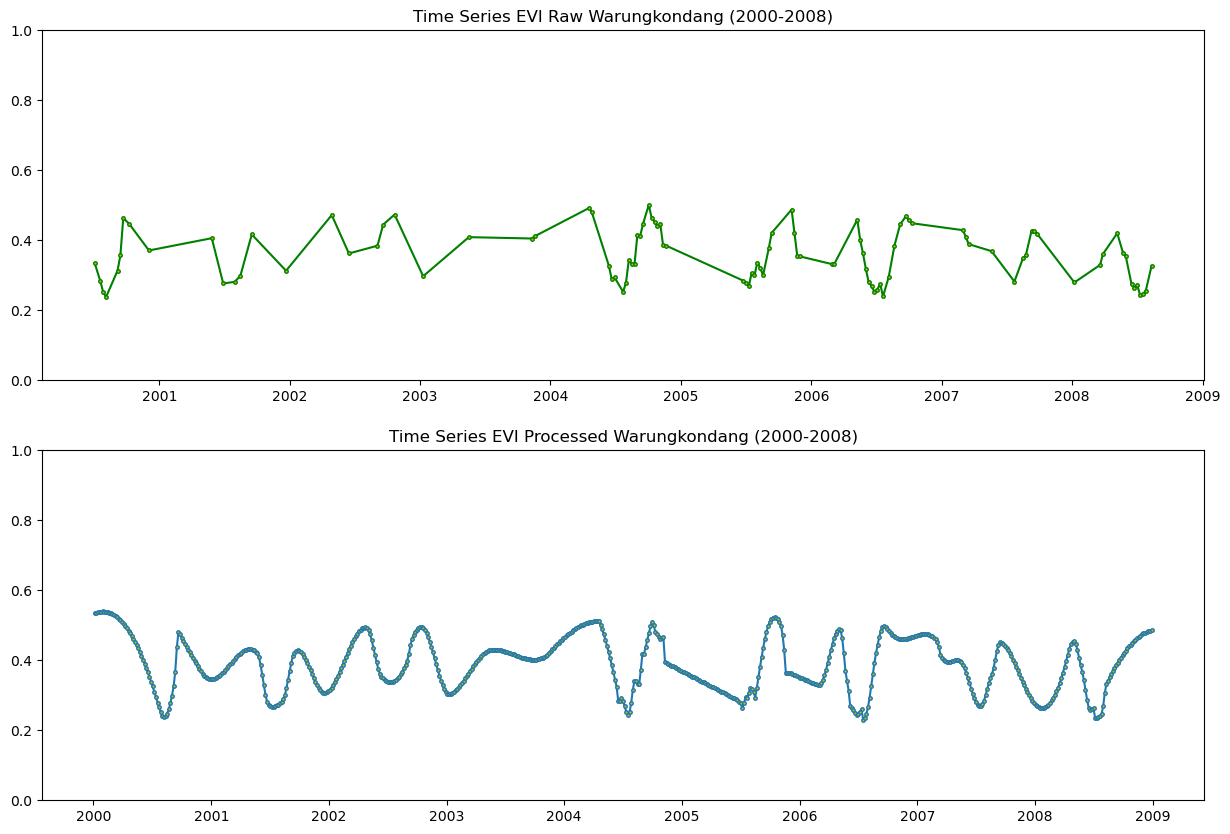

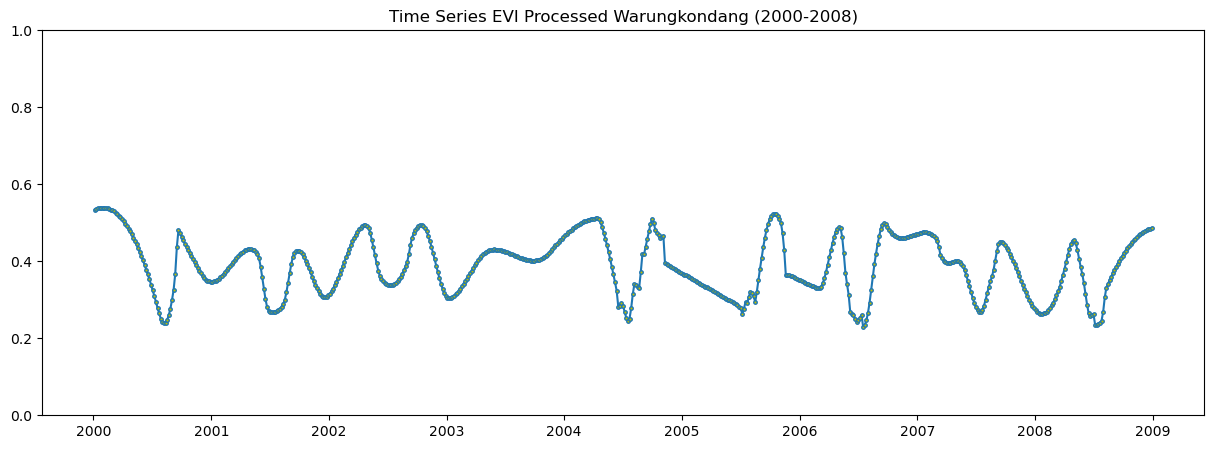

In [11]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 2)
plt.ylim(0, 1)
plt.plot(viz_df.index, viz_df[selected_stat], marker='.', mfc='y', ms=5)
plt.title(f'Time Series EVI Processed {selected_kec.title()} ({start_year}-{end_year})',)
plt.subplot(2, 1, 1)
plt.ylim(0, 1)
plt.plot(raw_formatted.index, raw_formatted[selected_stat], color='green', marker='.', mfc='y', ms=5)
plt.title(f'Time Series EVI Raw {selected_kec.title()} ({start_year}-{end_year})')
plt.savefig(f'temp_viz/temp.png')
plt.show()

plt.figure(figsize=(15, 5))
plt.ylim(0, 1)
plt.plot(viz_df.index, viz_df[selected_stat], marker='.', mfc='y', ms=5)
plt.title(f'Time Series EVI Processed {selected_kec.title()} ({start_year}-{end_year})',)
plt.savefig(f'temp_viz/temp2.png')
plt.show()

In [ ]:
chart_df = viz_df.copy()
chart_df = chart_df.rename(columns={'mean':'evi'})
chart_df = chart_df['evi']

chart_df.to_csv(f"pandanwangi_timeseries/extracted_chart/{selected_kec}.csv")
print(chart_df)

In [ ]:
selected_stat = 'mean'
plt.figure(figsize=(15, 2.6))

print(viz_df[selected_stat])

decomposition = seasonal_decompose(viz_df[selected_stat], period=36)
decomposition_2 = seasonal_decompose(nonpw_viz_df[selected_stat], period=36)
# plt.plot(viz_df.index, viz_df[selected_stat])
# plt.title(f'Time Series Plot EVI {selected_kec} ({start_year}-{end_year})')

# plt.subplot(4, 1, 1)
# decomposition.observed.plot(title=f'Time Series Plot EVI Pandanwangi {selected_kec.title()} ({start_year}-{end_year})')
# plt.xlabel('Tahun')
# plt.ylabel(f'{selected_stat.title()} EVI')
# plt.subplot(4, 1, 2)
# plt.xlabel('Tahun')
# decomposition.trend.plot()
# plt.subplot(2, 1, 1)
# plt.xlabel('Tahun')
decomposition.seasonal.plot()
# plt.subplot(2, 1, 2)
# plt.xlabel('Tahun')
# decomposition_2.seasonal.plot(title='Seasonal Component Non-Pandanwangi dengan Periode 5 Bulan', color='orange')
# plt.subplot(4, 1, 4)
# plt.xlabel('Tahun')
# decomposition.resid.plot(title='Residual Component')
# plt.tight_layout()
plt.savefig(f'temp_viz/dekomposisi_ts.png')


In [ ]:
plt.show()

# Analisis Deskriptif Cuaca

In [492]:
def climate_df_processing(df):
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')
    df.set_index('datetime', inplace=True)
    df = df.interpolate(axis=1)
    df = df.ffill(axis=1)
    df = df.bfill(axis=1)
    return df

In [543]:
clim_df = climate_df_processing(pd.read_csv(climate_dir))

In [544]:
print(f"features list: {clim_df.columns}")
# era5
# clims = ['temperature_2m', 'soil_temperature_level_1', 'volumetric_soil_water_layer_1', 'total_precipitation_sum', 'dewpoint_temperature_2m', 'surface_net_solar_radiation_sum']
# names = ['t2m', 'st1', 'vsm1', 'ps', 'dt2m', 'solar']
# clims = ['temperature_range']
# names = ['tr']

# chirts
# clims = ['heat_index', 'minimum_temperature', 'maximum_temperature', 'relative_humidity', 'temperature_range']
# names = ['heat', 'mintemp', 'maxtemp', 'humid', 'trange']

# merra2
# clims = ['T2M', 'TS', 'T2M_RANGE', 'PS', 'WS2M', 'GWETTOP']
# names = ['power_t2m', 'power_ts', 'power_t2m_range', 'power_ps', 'power_ws2m', 'power_gwettop']

#OpenWeather
clims = ['temp', 'temp_range', 'pressure', 'humidity', 'rain_sum', 'clouds_all']
names = ['ow_temp', 'ow_tr', 'ow_press', 'ow_humid', 'ow_rain', 'ow_clouds', 'ow_clouds']


features list: Index(['temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'clouds_all',
       'temp_range', 'rain_sum'],
      dtype='object')


In [545]:
start_year = 1960
end_year = 2024
viz_df = clim_df[(clim_df.index.year >= start_year) & (clim_df.index.year <= end_year)]

temp secara iklim pada 2016-07-01 00:00:00 adalah 24.669061872146134 dan pada 2022-05-29 00:00:00 adalah 24.57113127853881
temp_range secara iklim pada 2016-07-01 00:00:00 adalah 1.8939248858447482 dan pada 2022-05-29 00:00:00 adalah 1.9631212328767136
pressure secara iklim pada 2016-07-01 00:00:00 adalah 1011.7415068493139 dan pada 2022-05-29 00:00:00 adalah 1011.5680821917799
humidity secara iklim pada 2016-07-01 00:00:00 adalah 83.57132420091325 dan pada 2022-05-29 00:00:00 adalah 84.74246575342453
rain_sum secara iklim pada 2016-07-01 00:00:00 adalah 0.3198141552511414 dan pada 2022-05-29 00:00:00 adalah 0.3127493150684931
clouds_all secara iklim pada 2016-07-01 00:00:00 adalah 80.77739726027391 dan pada 2022-05-29 00:00:00 adalah 79.95337899543382


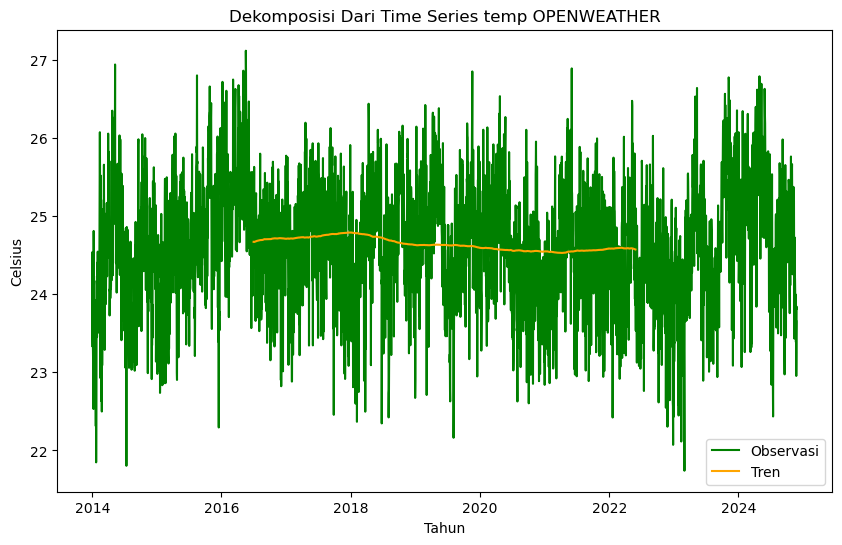

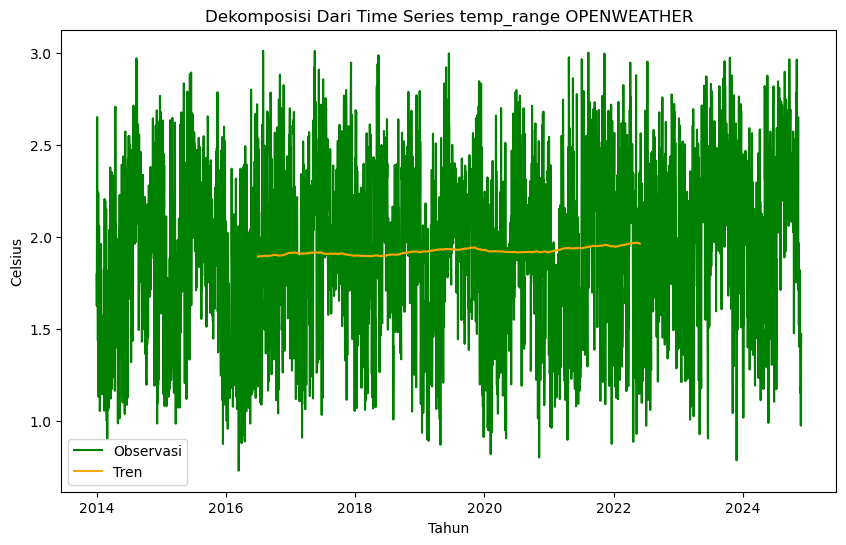

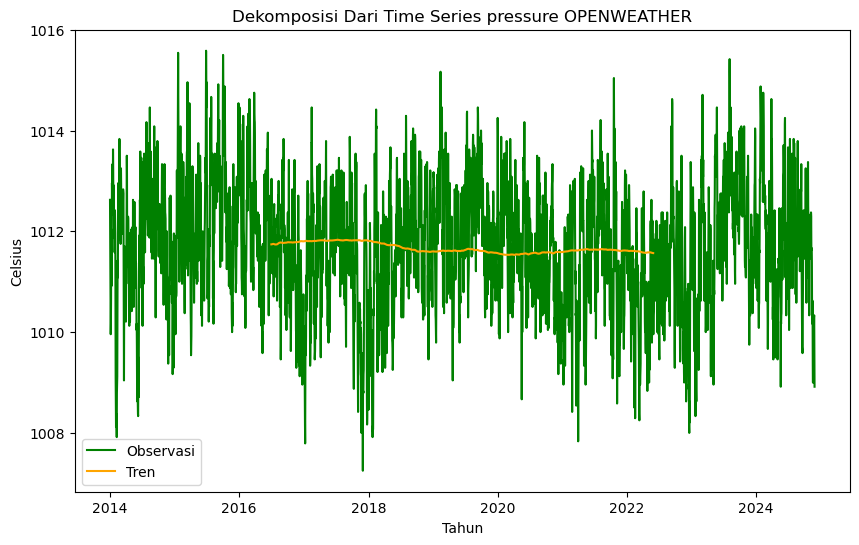

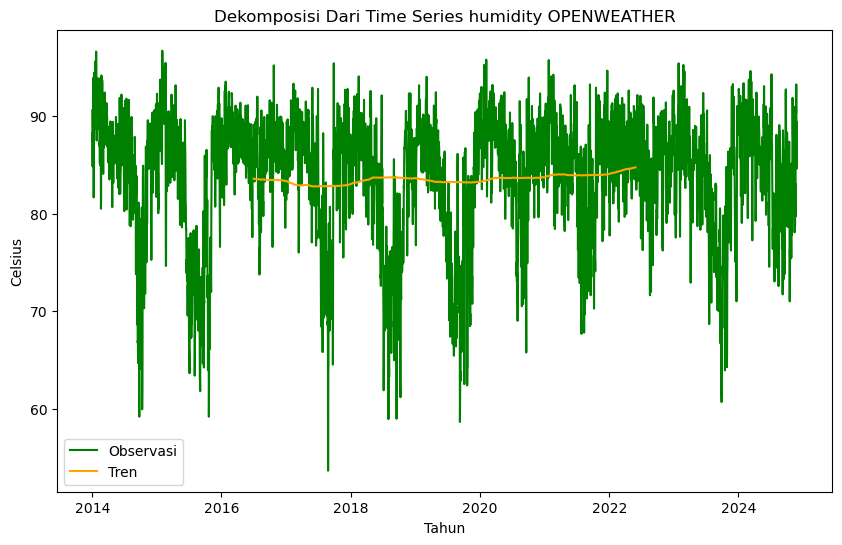

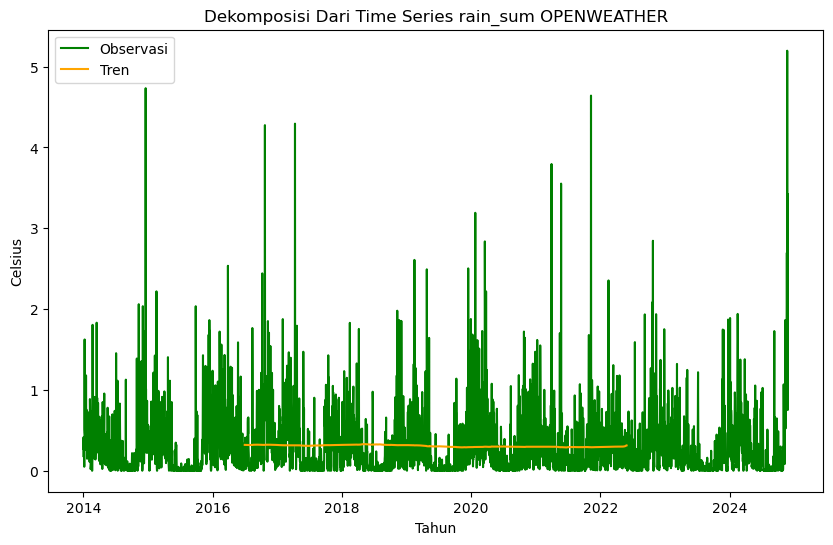

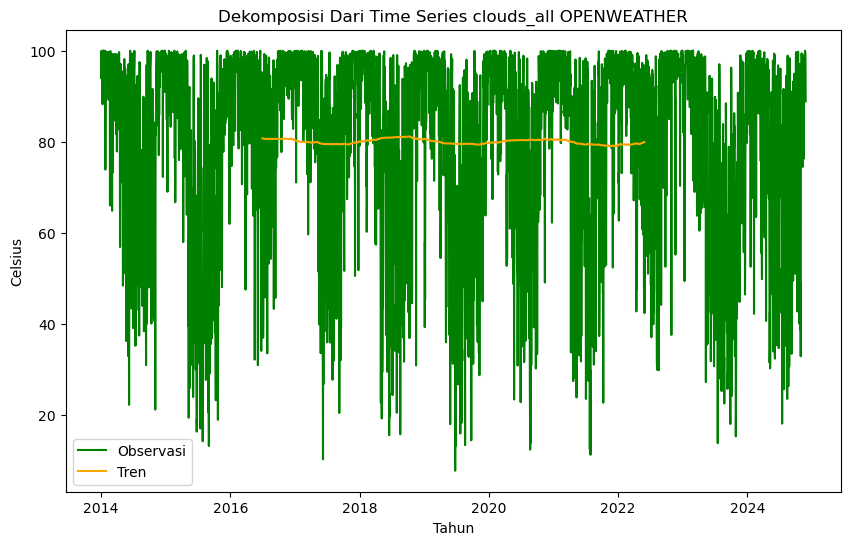

In [546]:
for idx, clim in enumerate(clims):
    decomposition = seasonal_decompose(viz_df[clim], period=1825)
    plt.figure(figsize=(10, 6))
    
    # Plot real data (observed)
    plt.plot(decomposition.observed, label='Observasi', color='green')
    
    # Plot trend
    plt.plot(decomposition.trend, label='Tren', color='orange')
    
    # Plot seasonal
    # plt.plot(decomposition.seasonal, label='Seasonal', color='red', marker='s')
    
    # Optional: add grid and labels
    plt.title(f'Dekomposisi Dari Time Series {clim} {selected_clim.upper()}')
    plt.xlabel('Tahun')
    plt.ylabel('Celsius')
    plt.legend()
    # plt.grid(True)
    plt.savefig(f'temp_viz/deskriptif_cuaca/{selected_kec}/{names[idx]}.png')
    climate_trend = decomposition.trend
    non_na = climate_trend.dropna()
    first_non_null = non_na.iloc[0]
    first_date = non_na.index[0]
    last_non_null = non_na.iloc[-1]
    last_date = non_na.index[-1]
    print(f'{clim} secara iklim pada {first_date} adalah {first_non_null} dan pada {last_date} adalah {last_non_null}')
    # plt.show()

datetime
2014-01-01   -0.464091
2014-01-02   -0.553672
2014-01-03   -0.367927
2014-01-04   -0.001138
2014-01-05   -0.317097
                ...   
2024-11-22   -0.021291
2024-11-23   -0.142019
2024-11-24   -0.408615
2024-11-25   -0.414737
2024-11-26   -0.331937
Name: seasonal, Length: 3983, dtype: float64
datetime
2014-01-01   -0.007272
2014-01-02    0.039527
2014-01-03    0.066652
2014-01-04    0.068688
2014-01-05    0.190865
                ...   
2024-11-22    0.128582
2024-11-23    0.107885
2024-11-24    0.234916
2024-11-25    0.233051
2024-11-26    0.025805
Name: seasonal, Length: 3983, dtype: float64
datetime
2014-01-01   -0.202883
2014-01-02    0.063270
2014-01-03   -0.003773
2014-01-04   -0.333134
2014-01-05   -0.500075
                ...   
2024-11-22   -1.012963
2024-11-23   -1.062871
2024-11-24   -0.913168
2024-11-25   -0.804949
2024-11-26   -0.521821
Name: seasonal, Length: 3983, dtype: float64
datetime
2014-01-01    4.630875
2014-01-02    4.171525
2014-01-03    2.978386
2

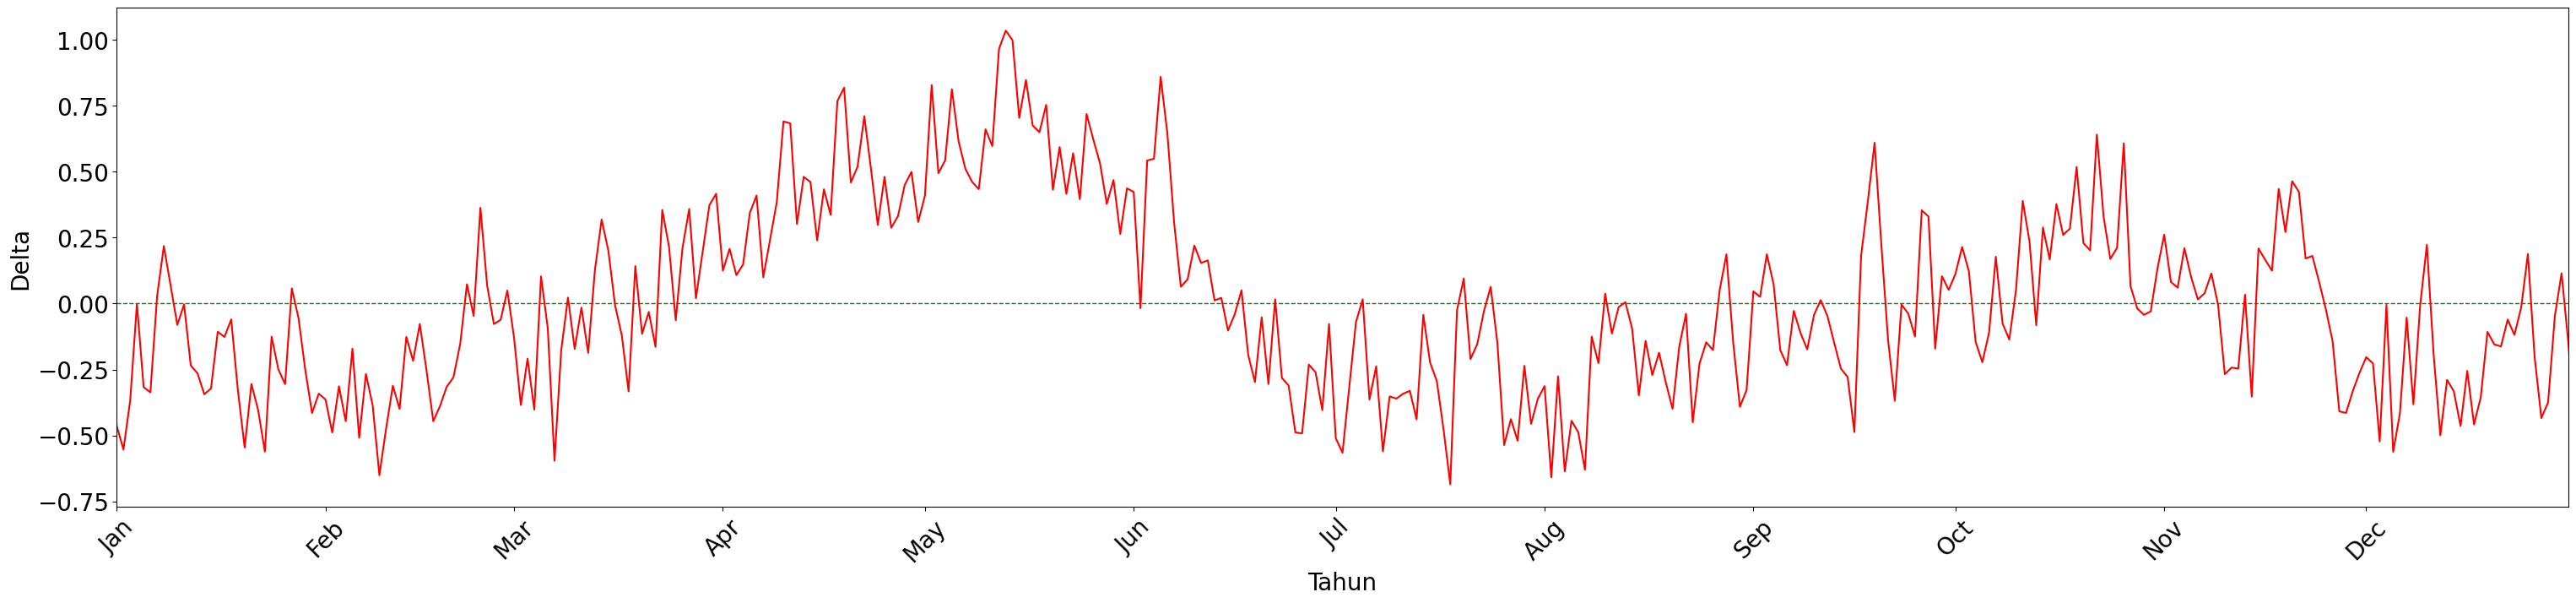

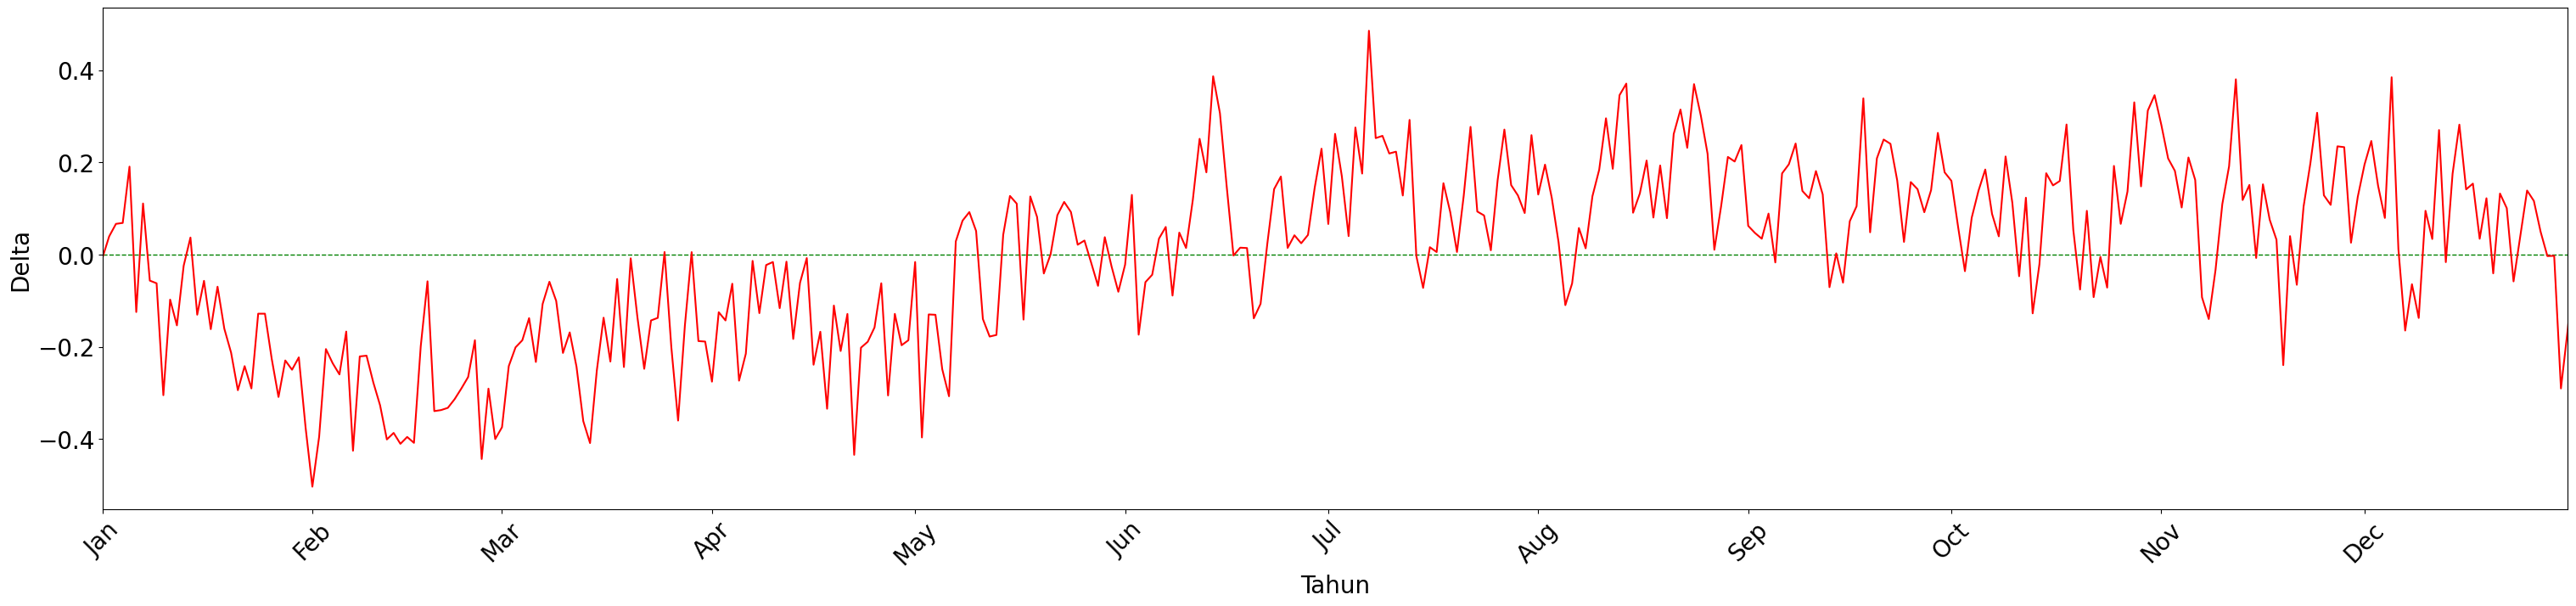

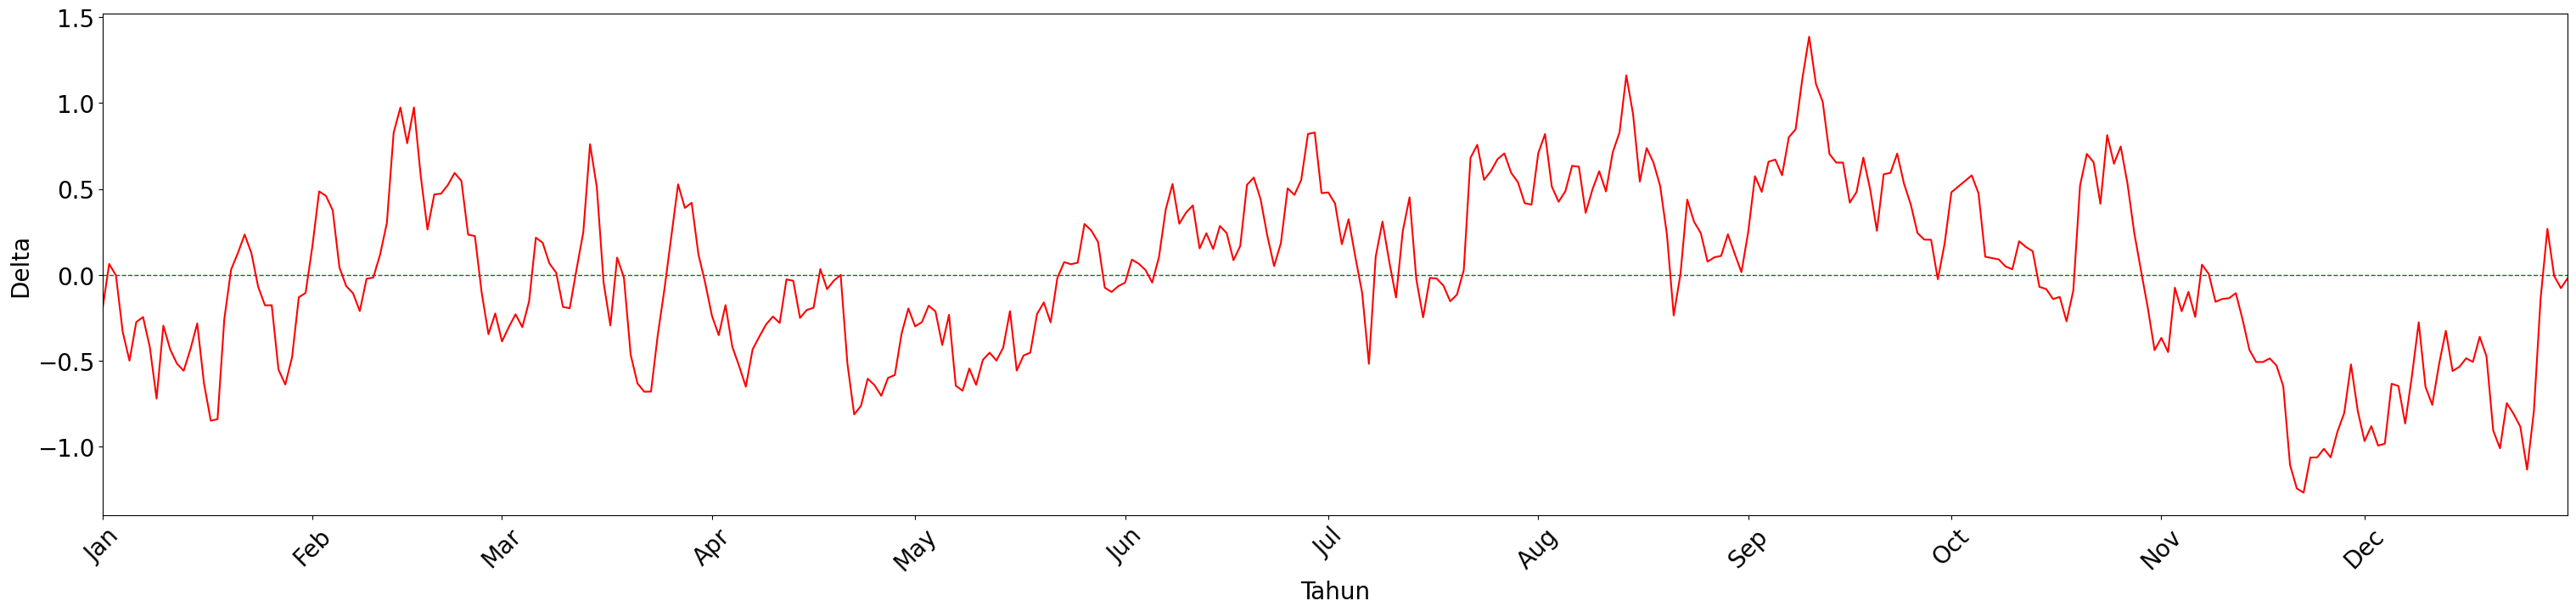

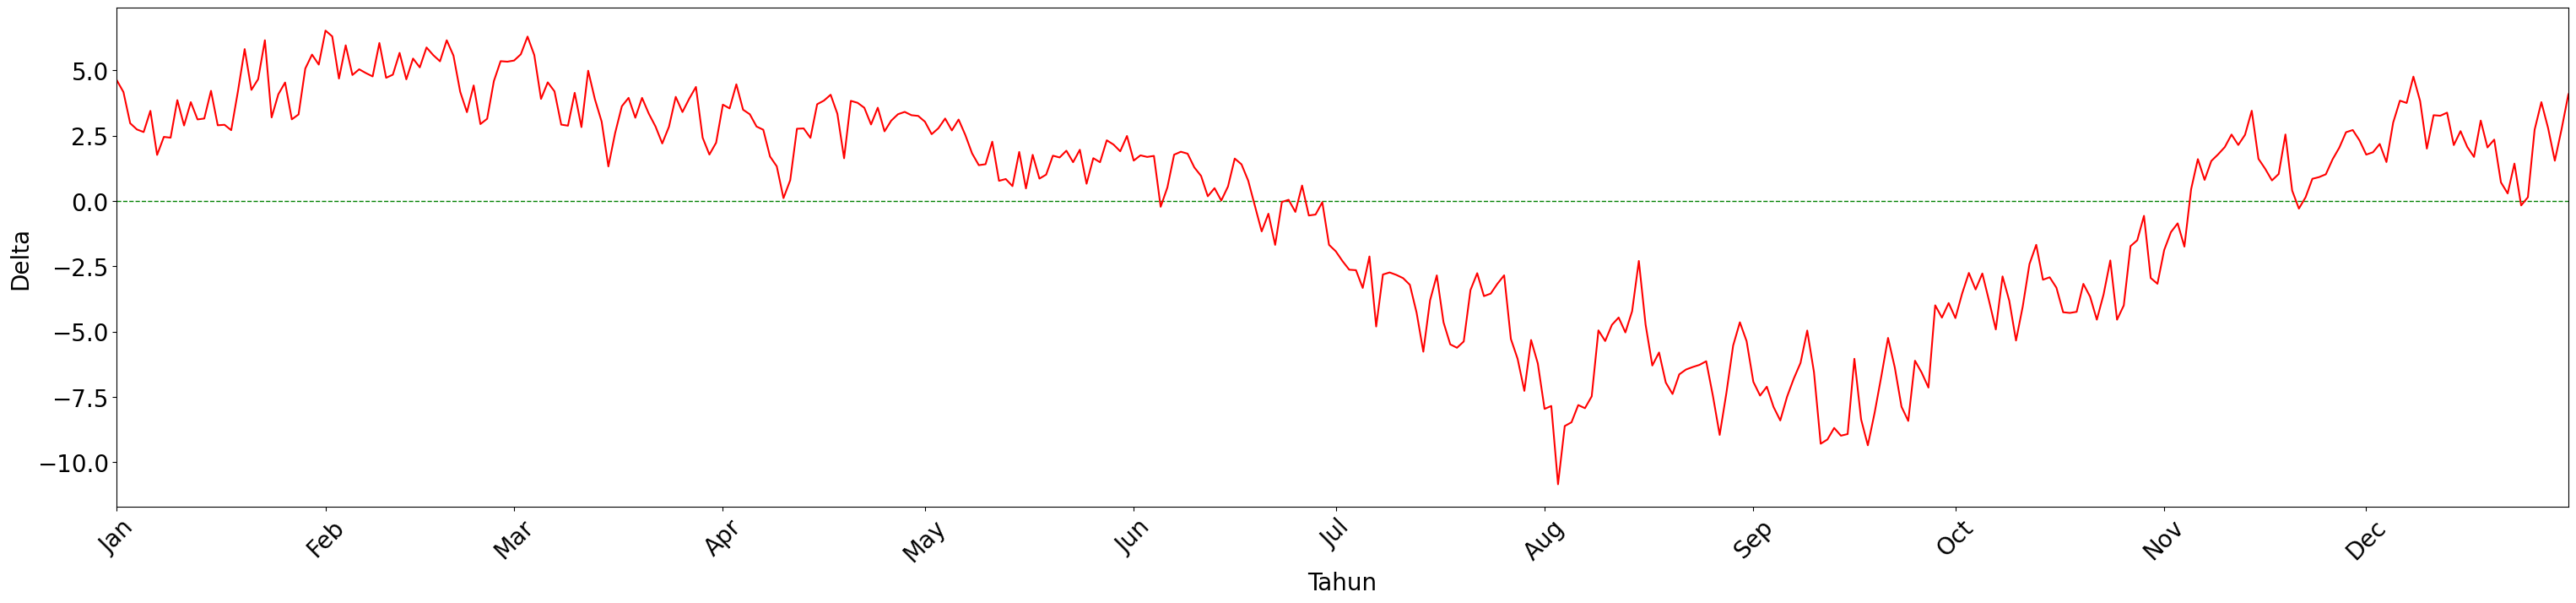

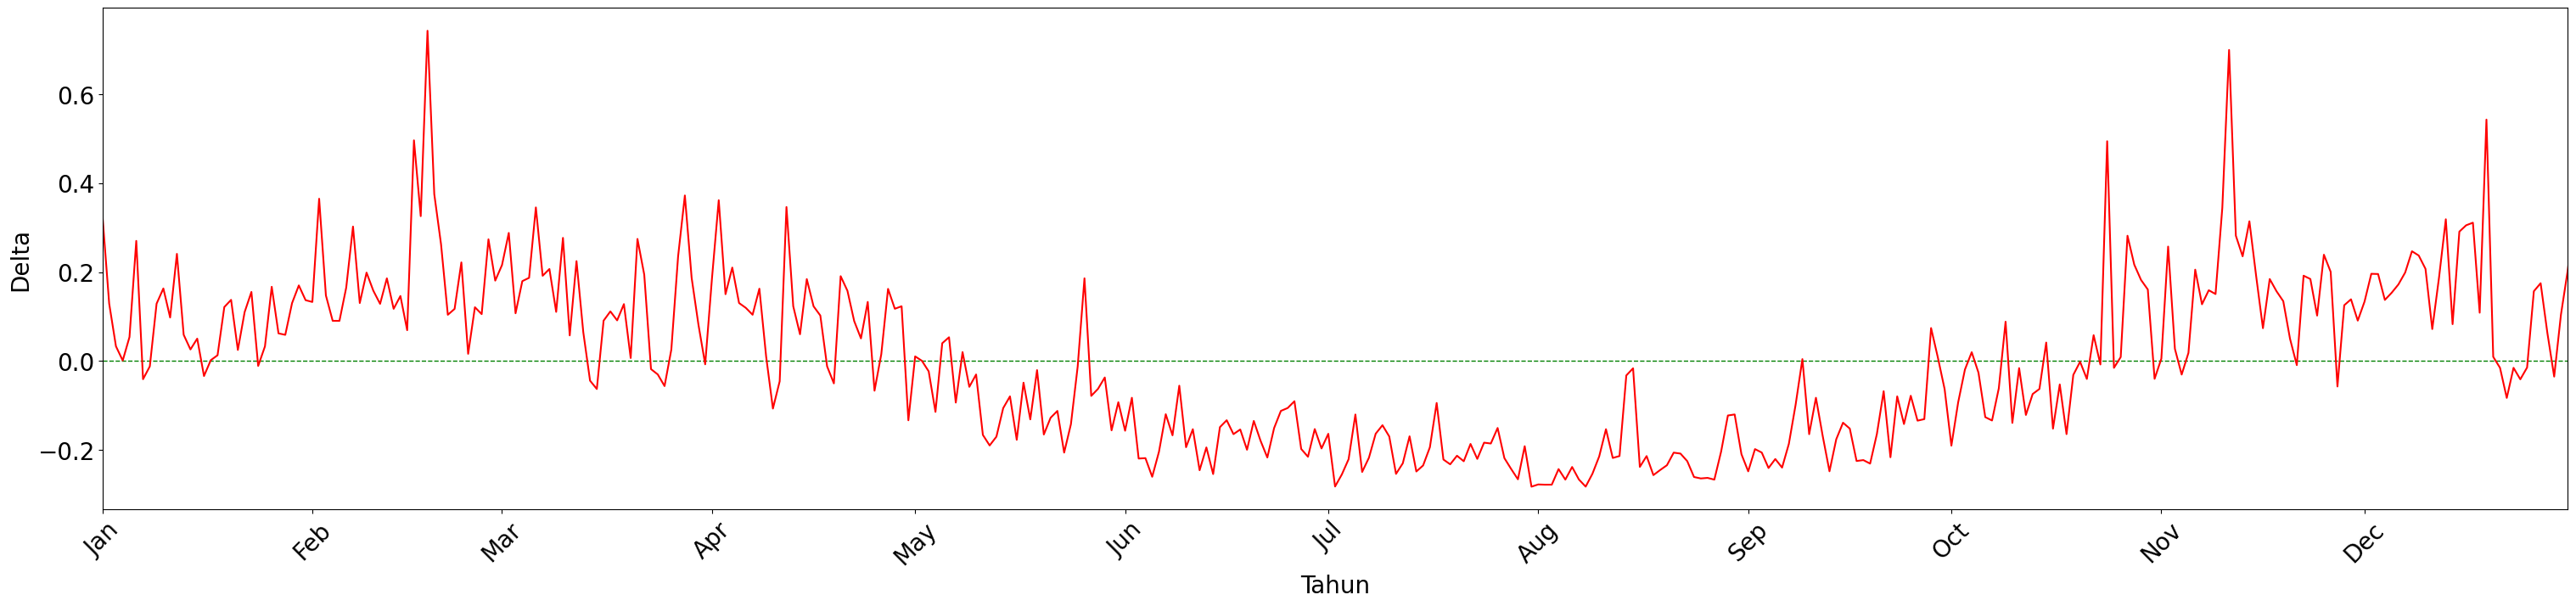

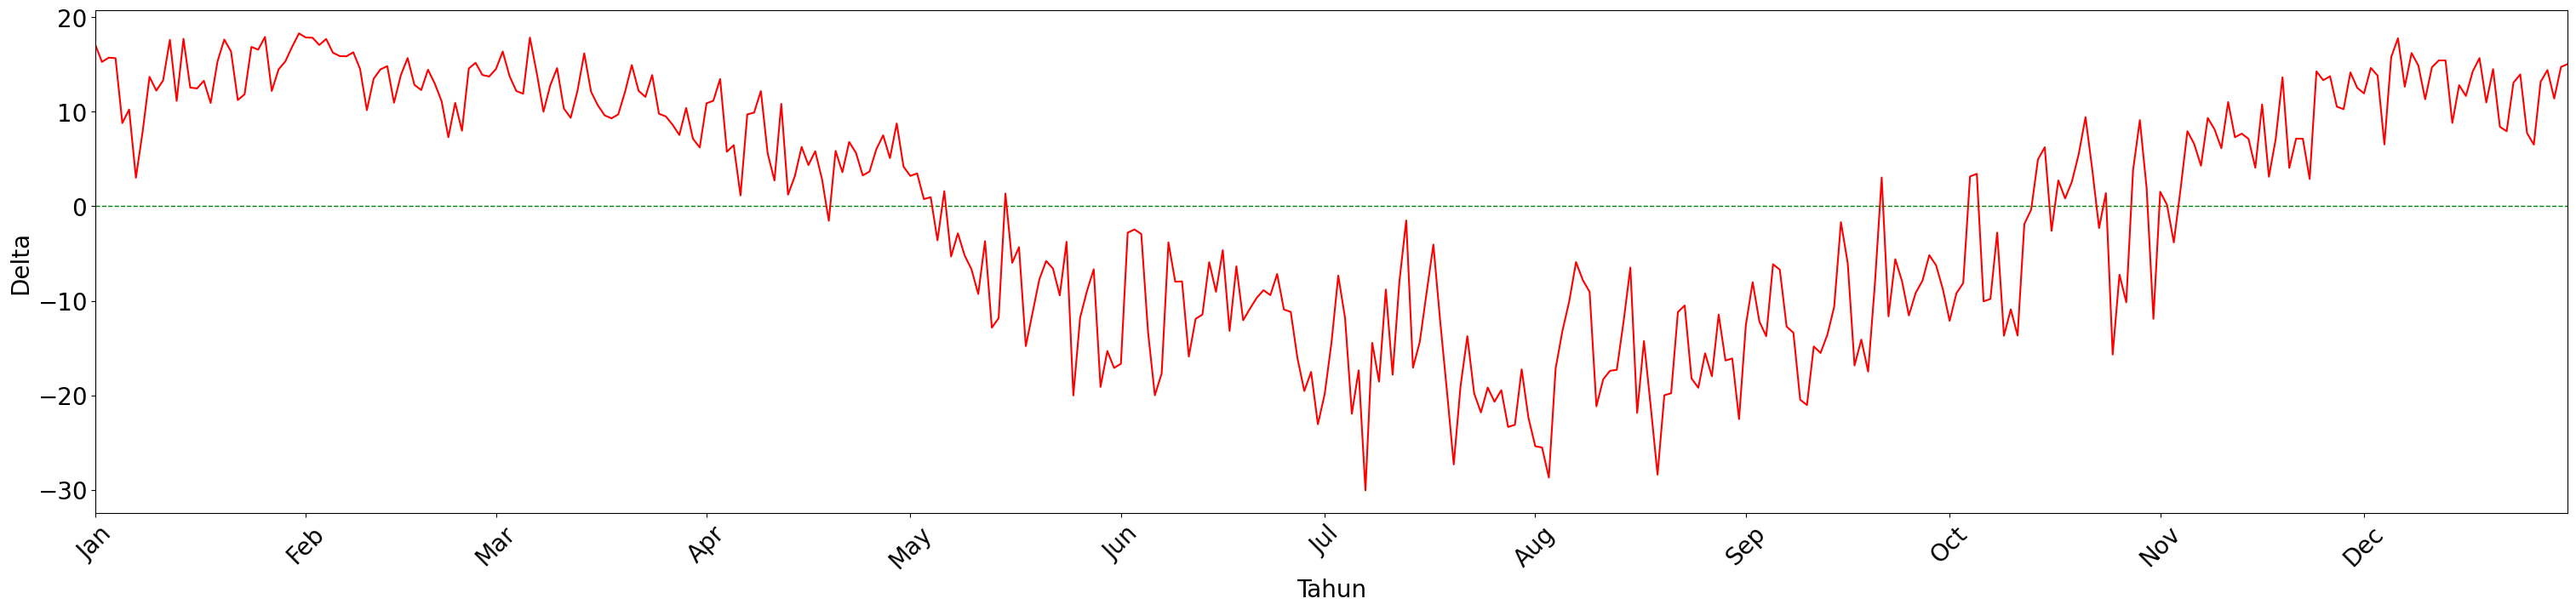

In [549]:

for idx, clim in enumerate(clims):

    plt.figure(figsize=(30, 7))
    decomposition = seasonal_decompose(viz_df[clim], period=365)
    print(decomposition.seasonal)
    plt.xlabel('Tahun', fontsize=20)
    plt.ylabel('Delta', fontsize=20)
    plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-12-31'))
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.axhline(y=0, color='green', linestyle='--', linewidth=1)
    
    # Rotate labels for clarity
    plt.xticks(rotation=45)
    
    # Optional: Adjust layout
    plt.tight_layout()
    
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.plot(decomposition.seasonal, label='Seasonal', color='red')
    plt.savefig(f'temp_viz/deskriptif_cuaca/{selected_kec}/{selected_clim}/ow_zoom_{clim}.png')
    # plt.show()
# plt.plot(seasonal_ma, label='Seasonal', color='red')

##### 